To do notes
- check how fixed H matrix in nmf impacts quality of reconstruction vs variable H
- whats an acceptable mse for nmf reconstruction
- Use VisiumHD Dataset as a standin for "complete" Xenium dataset (how does the chosen panel impact reconstruction, what properties do nicely reconstructed genes have)

## Prepare Environment

### Modules

In [196]:
from pathlib import Path
from typing import Union
import itertools
import functools
import warnings
from math import ceil, sqrt

import numpy as np
np.random.seed(5)
import pandas as pd
import torch
import scvi
import scanpy as sc
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print(
    torch.backends.mps.is_available(),
    torch.cuda.is_available()
)

True False


### Utils

In [3]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

### Folder Structure

In [4]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

### Dataloading

In [5]:
adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
adata_sp, adata_sc

(AnnData object with n_obs × n_vars = 7416 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 2239 × 32287
     obs: 'cluster')

### Dataprep

In [6]:
# Choose one celltype from the available shared types to filter adata objects with
set.intersection(
    set(adata_sc.obs["cluster"]),
    set(adata_sp.obs["nico_ct"])
)

{'BZE',
 'Blood vasc.',
 'Cycling/GC B cell',
 'Glial',
 'Goblet',
 'Lymphatic',
 'MZE',
 'Macrophage',
 'Paneth',
 'Plasma',
 'Rest B',
 'Stem/TA',
 'Stroma',
 'T cell',
 'TZE',
 'Tuft',
 'cDC/monocyte',
 'neurons/enteroendocrine',
 'pDC'}

In [7]:
celltype = "Stem/TA"
adata_sc_filtered = adata_sc[adata_sc.obs["cluster"] == celltype].copy()
adata_sp_filtered = adata_sp[adata_sp.obs["nico_ct"] == celltype].copy()
adata_sc_filtered, adata_sp_filtered

(AnnData object with n_obs × n_vars = 420 × 32287
     obs: 'cluster',
 AnnData object with n_obs × n_vars = 997 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances')

In [17]:
from fixed_matrix_NMF import _fit_transform_adapted
from sklearn.decomposition._nmf import _beta_divergence
from sklearn._config import config_context

X = adata_sc_filtered.X.toarray().copy().T
with config_context(assume_finite=True):
    W, H, n_iter = _fit_transform_adapted(X, n_components=3, W=None, H=None)

reconstruction_err_ = _beta_divergence(X, W, H, "frobenius", square_root=True)

/Users/egerc/Documents/Projects/spatial_transcript_inference/fixed_matrix_NMF.py:217: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  "Maximum number of iterations %d reached. Increase "


In [33]:
H = np.random.rand(3, 420)
H

array([[0.75163396, 0.08539558, 0.97078464, ..., 0.1439378 , 0.90717767,
        0.32783572],
       [0.07866333, 0.30733483, 0.42359012, ..., 0.87060032, 0.6236801 ,
        0.29109156],
       [0.91260165, 0.27565979, 0.33751952, ..., 0.04761256, 0.85548973,
        0.58396665]])

In [36]:
X = adata_sc_filtered.X.toarray().copy().T
with config_context(assume_finite=True):
    W, H, n_iter = _fit_transform_adapted(X, n_components=3, W=None, H=None)

reconstruction_err_ = _beta_divergence(X, W, H, "frobenius", square_root=True)

/Users/egerc/Documents/Projects/spatial_transcript_inference/fixed_matrix_NMF.py:217: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  l1_reg_W=X.shape[0] * alpha_W * l1_ratio,


In [40]:
H

array([[21.26169   , 28.685776  , 16.04824   , ...,  0.12589197,
         0.52733135,  0.        ],
       [ 1.7029613 ,  0.        , 13.322943  , ...,  2.792106  ,
         1.4286672 ,  0.93392205],
       [17.670887  , 10.896987  , 15.449162  , ...,  0.        ,
         0.        ,  0.08054076]], dtype=float32)

## Benchmarking

In [42]:
model_nmf = sklearn.decomposition.NMF(
    n_components=3,
)
W = model_nmf.fit_transform(
   X=adata_sc_filtered.X.transpose(),
)
H = model_nmf.components_
sklearn.metrics.mean_squared_error(
    adata_sc_filtered.X.transpose().toarray(),
    W @ H
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


4.443472385406494

In [78]:
W, H, n_iter = non_negative_factorization(X, n_components=3, )

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


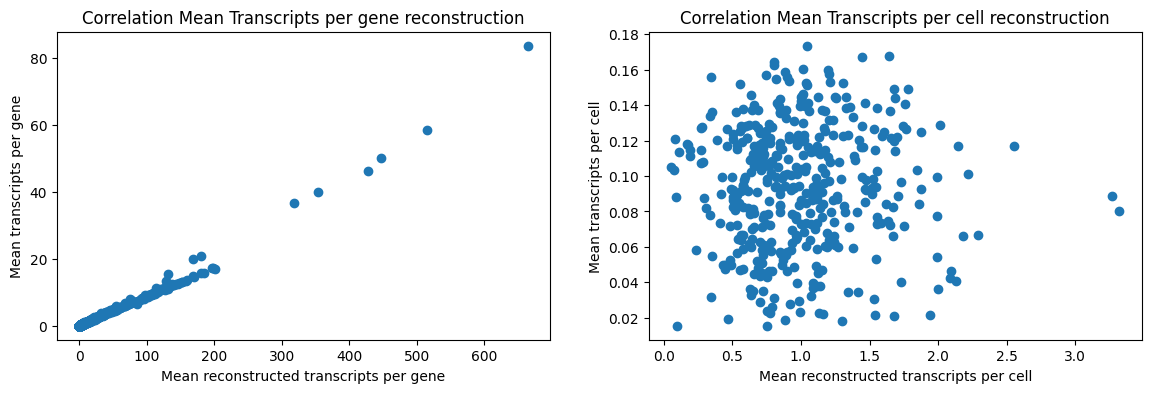

Correlation Coeff Gene Reconstruction: 0.9894838999078223 
Correlation Coeff Cell Reconstruction: 0.007004270274122609


In [81]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=1),
    (W @ H).mean(axis=1),
)
axs[0].set_title("Correlation Mean Transcripts per gene reconstruction")
axs[0].set_xlabel("Mean reconstructed transcripts per gene")
axs[0].set_ylabel("Mean transcripts per gene")

axs[1].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=0),
    (W @ H).mean(axis=0),
)
axs[1].set_title("Correlation Mean Transcripts per cell reconstruction")
axs[1].set_xlabel("Mean reconstructed transcripts per cell")
axs[1].set_ylabel("Mean transcripts per cell")
plt.show()

print(
    f"Correlation Coeff Gene Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=1), (W @ H).mean(axis=1))[0, 1]}",
    f"\nCorrelation Coeff Cell Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=0), (W @ H).mean(axis=0))[0, 1]}",
)

In [527]:
np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)

array([False, False, False, ..., False, False, False])

**Taken from the sklearn NMF class description:**

Non-Negative Matrix Factorization (NMF).

Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H)
whose product approximates the non-negative matrix X. This factorization can be used
for example for dimensionality reduction, source separation or topic extraction.

The objective function is:
$$
L(W, H) = \frac{1}{2} \| X - WH \|_{\text{loss}}^2
+ \alpha_W \cdot l1\_ratio \cdot n_{\text{features}} \cdot \|\text{vec}(W)\|_1
+ \alpha_H \cdot l1\_ratio \cdot n_{\text{samples}} \cdot \|\text{vec}(H)\|_1
+ \frac{1}{2} \alpha_W \cdot (1 - l1\_ratio) \cdot n_{\text{features}} \cdot \|W\|_{Fro}^2
+ \frac{1}{2} \alpha_H \cdot (1 - l1\_ratio) \cdot n_{\text{samples}} \cdot \|H\|_{Fro}^2
$$

where $||A||_{Fro}^2 = \sum_{i,j} A_{ij}^2$ (Frobenius norm) and
$||vec(A)||_1 = \sum_{i,j} abs(A_{ij})$ (Elementwise L1 norm).

The generic norm $\| X - WH \|_{\text{loss}}$ may represent
the Frobenius norm or another supported beta-divergence loss.
The choice between options is controlled by the `beta_loss` parameter.

The regularization terms are scaled by `n_features` for `W` and by `n_samples` for
`H` to keep their impact balanced with respect to one another and to the data fit
term as independent as possible of the size `n_samples` of the training set.

The objective function is minimized with an alternating minimization of W
and H.

Note that the transformed data is named W and the components matrix is named H. In
the NMF literature, the naming convention is usually the opposite since the data
matrix X is transposed.


In [43]:
from sklearn.decomposition import non_negative_factorization

In [84]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 4., 4., ..., 0., 2., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [158]:
X = adata_sc_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
W, H, n_iter = non_negative_factorization(X, W=None, n_components=10)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [101]:
H.shape

(3, 32287)

In [98]:
X = adata_sc_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
non_negative_factorization(X, W=None, H=H, n_components=3, update_H=False, init="custom")

ValueError: Array with wrong second dimension passed to NMF (input H). Expected 32287, but got 420.

In [160]:
H_sp = H[:, np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)]

In [161]:
X_sp = adata_sp_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
W_sp, H_sp, n_iter = non_negative_factorization(X_sp, W=None, H=H_sp, n_components=10, update_H=False, init="custom")

In [118]:
adata_sp_filtered.X.toarray().mean(axis=1).shape

(997,)

In [155]:
X_sp = adata_sp_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
W_sp, H_sp, n_iter = non_negative_factorization(X_sp, n_components=10)

In [131]:
(W_sp @ H_sp).shape


(7416, 203)

In [132]:
X_sp.shape

(7416, 203)

In [163]:
X_sp.mean(axis=0).shape

(203,)

In [164]:
X_sp.shape

(997, 203)

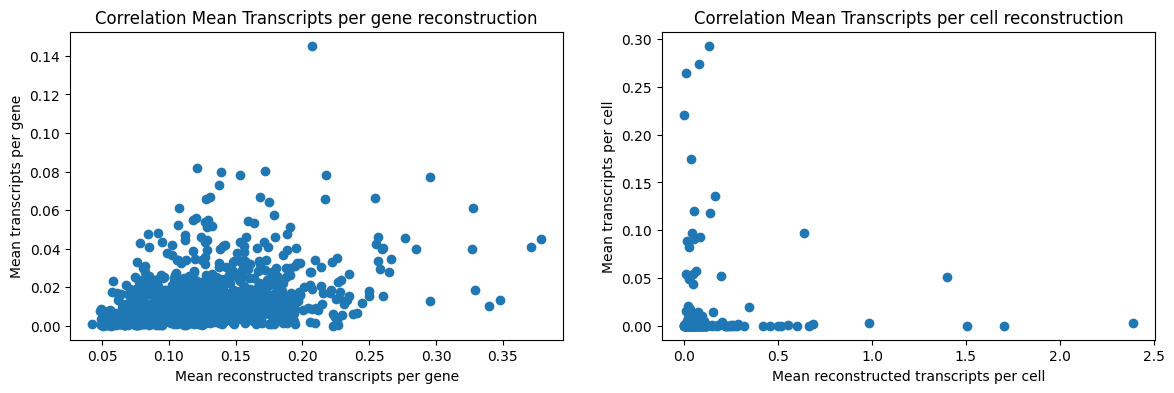

Correlation Coeff Gene Reconstruction: 0.36657244105478337 
Correlation Coeff Cell Reconstruction: -0.015983848718396563


In [162]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].scatter(
    X_sp.mean(axis=1),
    (W_sp @ H_sp).mean(axis=1),
)
axs[0].set_title("Correlation Mean Transcripts per gene reconstruction")
axs[0].set_xlabel("Mean reconstructed transcripts per gene")
axs[0].set_ylabel("Mean transcripts per gene")

axs[1].scatter(
    X_sp.mean(axis=0),
    (W_sp @ H_sp).mean(axis=0),
)
axs[1].set_title("Correlation Mean Transcripts per cell reconstruction")
axs[1].set_xlabel("Mean reconstructed transcripts per cell")
axs[1].set_ylabel("Mean transcripts per cell")
plt.show()

print(
    f"Correlation Coeff Gene Reconstruction: {np.corrcoef(X_sp.mean(axis=1), (W_sp @ H_sp).mean(axis=1))[0, 1]}",
    f"\nCorrelation Coeff Cell Reconstruction: {np.corrcoef(X_sp.mean(axis=0), (W_sp @ H_sp).mean(axis=0))[0, 1]}",
)

In [166]:
[i for i in range(1, 10)]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [173]:
adata_sp

AnnData object with n_obs × n_vars = 7416 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap', 'nico_ct_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [192]:
test_dict["Paneth"][9][0]

array([[5.1523119e-01, 3.0276515e-03, 7.0111202e-03, ..., 1.9051230e-01,
        0.0000000e+00, 2.5372884e-01],
       [8.1080520e-01, 1.4423761e-02, 0.0000000e+00, ..., 3.2399647e-02,
        2.7892178e-02, 5.1240359e-02],
       [9.6206558e-01, 0.0000000e+00, 0.0000000e+00, ..., 5.5307220e-03,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.6801058e-01, 4.3543191e-03, 0.0000000e+00, ..., 4.0645753e-03,
        5.3979900e-05, 0.0000000e+00],
       [8.0681711e-01, 0.0000000e+00, 0.0000000e+00, ..., 2.5862695e-03,
        0.0000000e+00, 0.0000000e+00],
       [8.9640546e-01, 7.7594060e-04, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
plt.scatter()

In [226]:
np.array(range(1, 10))

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
plt.lin

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

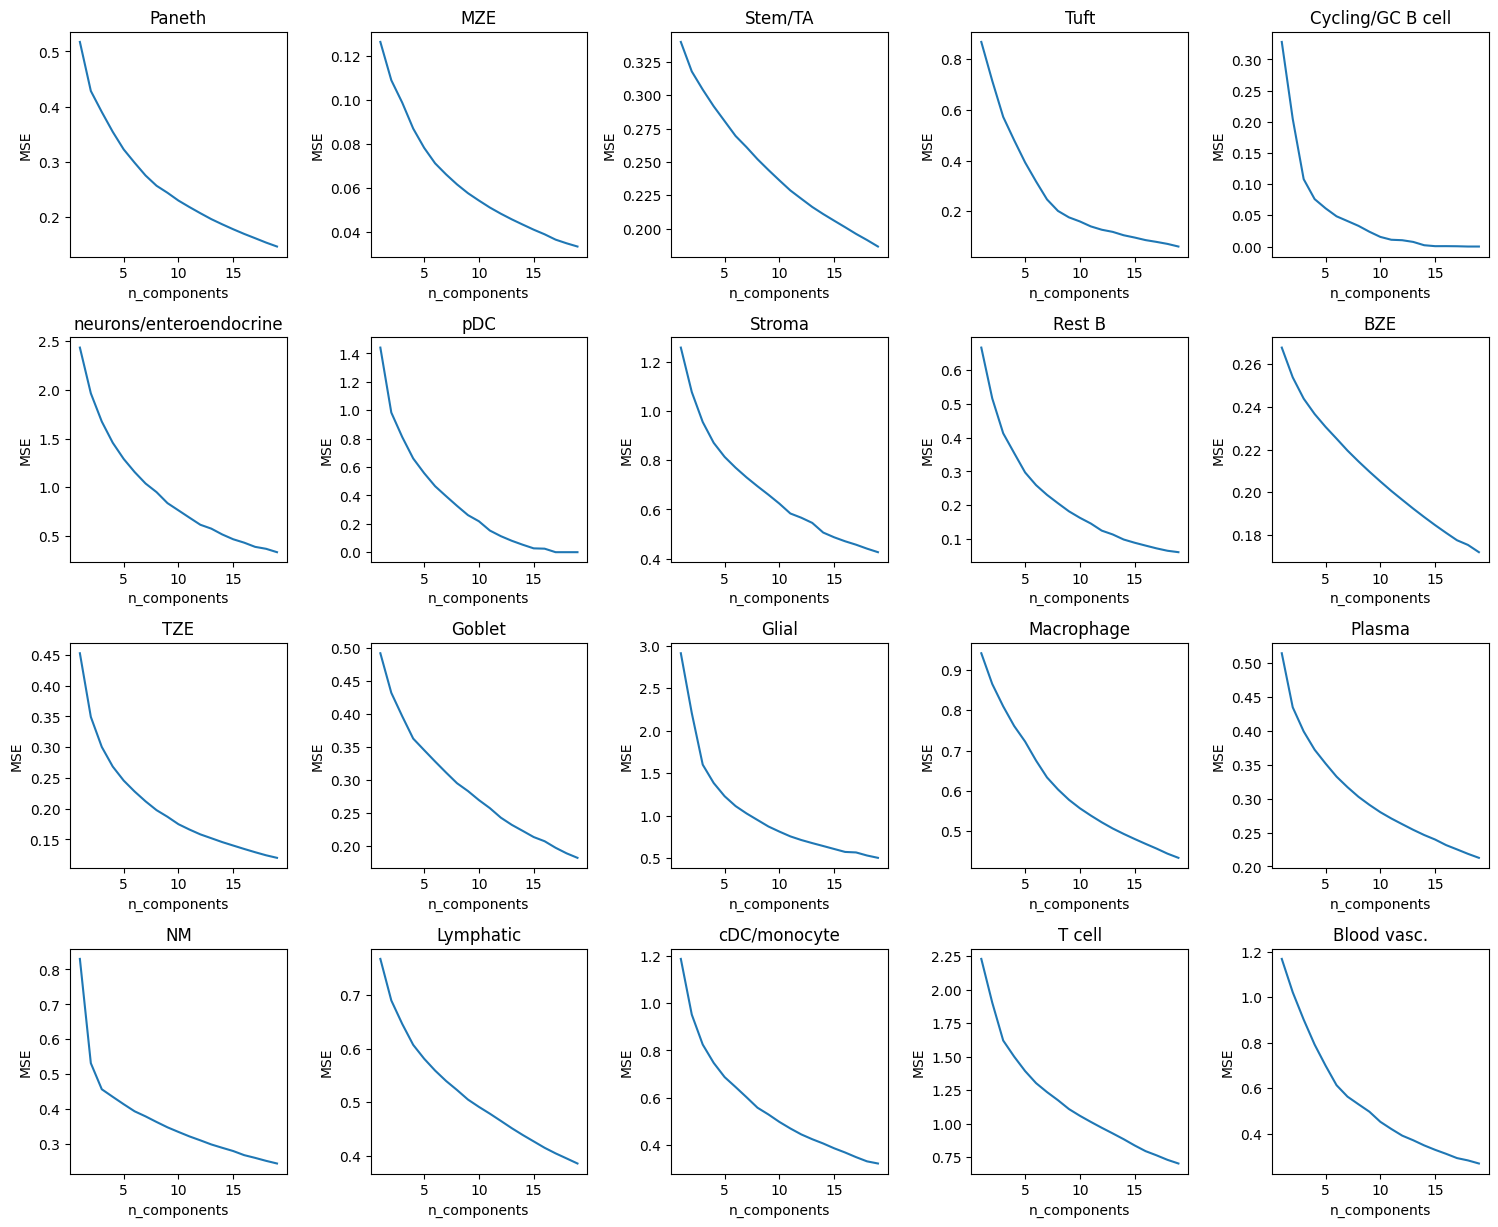

In [238]:
cell_types = set(adata_sp.obs["nico_ct"])
n_components_limit = 20
n_cell_types = len(cell_types)
grid_size = ceil(sqrt(n_cell_types))  # Square-like grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 3, grid_size * 3))  # Adjust figure size
axes = axes.flatten()
for i, cell_type in enumerate(cell_types):
    ax = axes[i] 
    X = adata_sp[adata_sp.obs["nico_ct"] == cell_type].X.toarray().copy()
    errors = [
        sklearn.metrics.mean_squared_error(
            X,
            functools.reduce(
                lambda a, b: a @ b,
                non_negative_factorization(X, n_components=n_components)[:2]
            )
        ) for n_components in range(1, n_components_limit)
    ]
    ax.plot(range(1, n_components_limit), errors)
    ax.set_title(cell_type)
    ax.set_xlabel("n_components")
    ax.set_ylabel("MSE")
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


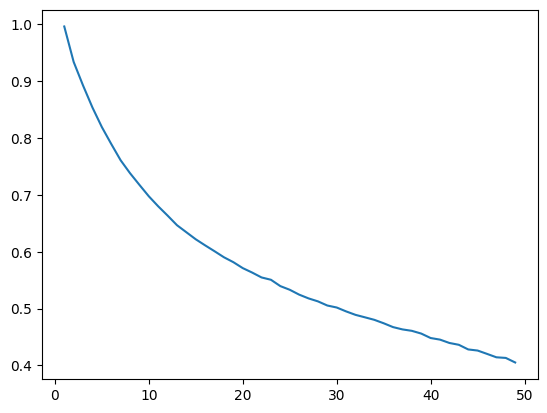

In [237]:
n_components_limit = 50
plt.plot(
    np.array(range(1, n_components_limit)),
    np.array([sklearn.metrics.mean_squared_error(
        adata_sp.X.toarray().copy(),
        functools.reduce(
            lambda a, b: a @ b,
            non_negative_factorization(adata_sp.X.toarray().copy(), n_components=n_components)[:2]
        )
    ) for n_components in range(1, n_components_limit)]),
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

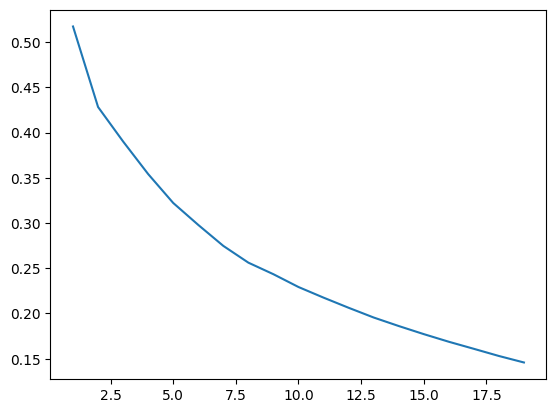

In [235]:
n_components_limit = 20
plt.plot(
    np.array(range(1, n_components_limit)),
    np.array([sklearn.metrics.mean_squared_error(
        adata_sp[adata_sp.obs["nico_ct"] == "Paneth"].X.toarray().copy(),
        functools.reduce(
            lambda a, b: a @ b,
            non_negative_factorization(adata_sp[adata_sp.obs["nico_ct"] == "Paneth"].X.toarray().copy(), n_components=n_components)[:2]
        )
    ) for n_components in range(1, n_components_limit)]),
)

In [254]:
len(list(set(adata_sp.obs["nico_ct"])))

20

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

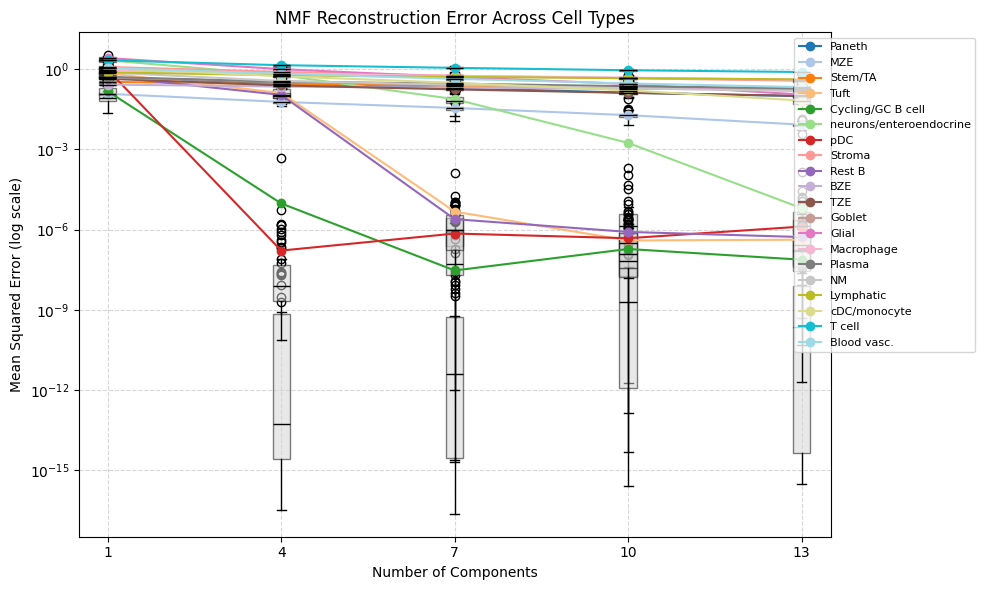

In [269]:
n_components_range = range(1, 15, 3) 
n_repeats = 50 
sample_fraction = 0.2 
cell_types = list(set(adata_sp.obs["nico_ct"]))[:20]  
palette = sns.color_palette("tab20", len(cell_types))
boxplot_data = {n: [] for n in n_components_range}
means = {n: [] for n in n_components_range}

for cell_type in cell_types:
    X_full = adata_sp[adata_sp.obs["nico_ct"] == cell_type].X.toarray().copy()
    n_samples = X_full.shape[0]
    for n_components in n_components_range:
        mse_values = []
        for _ in range(n_repeats):
            sampled_indices = np.random.choice(n_samples, int(sample_fraction * n_samples), replace=False)
            X_sampled = X_full[sampled_indices, :]
            W, H = non_negative_factorization(X_sampled, n_components=n_components)[:2]
            X_reconstructed = W @ H
            mse = sklearn.metrics.mean_squared_error(X_sampled, X_reconstructed)
            mse_values.append(mse)
        boxplot_data[n_components].append(mse_values)
        means[n_components].append(np.mean(mse_values))  # Store mean for line plot

plt.figure(figsize=(10, 6))

positions = list(n_components_range)
for i, n_components in enumerate(n_components_range):
    plt.boxplot(
        boxplot_data[n_components], 
        positions=[positions[i]] * len(cell_types),
        widths=0.3, 
        patch_artist=True, 
        boxprops=dict(facecolor="lightgray", alpha=0.5), 
        medianprops=dict(color='black')
    )

for i, (cell_type, color) in enumerate(zip(cell_types, palette)):
    mean_values = [means[n][i] for n in n_components_range]
    plt.plot(positions, mean_values, marker="o", linestyle="-", color=color, label=cell_type)

plt.xticks(positions, n_components_range)  
plt.xlabel("Number of Components")
plt.ylabel("Mean Squared Error (log scale)")
plt.yscale("log")
plt.title("NMF Reconstruction Error Across Cell Types")
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

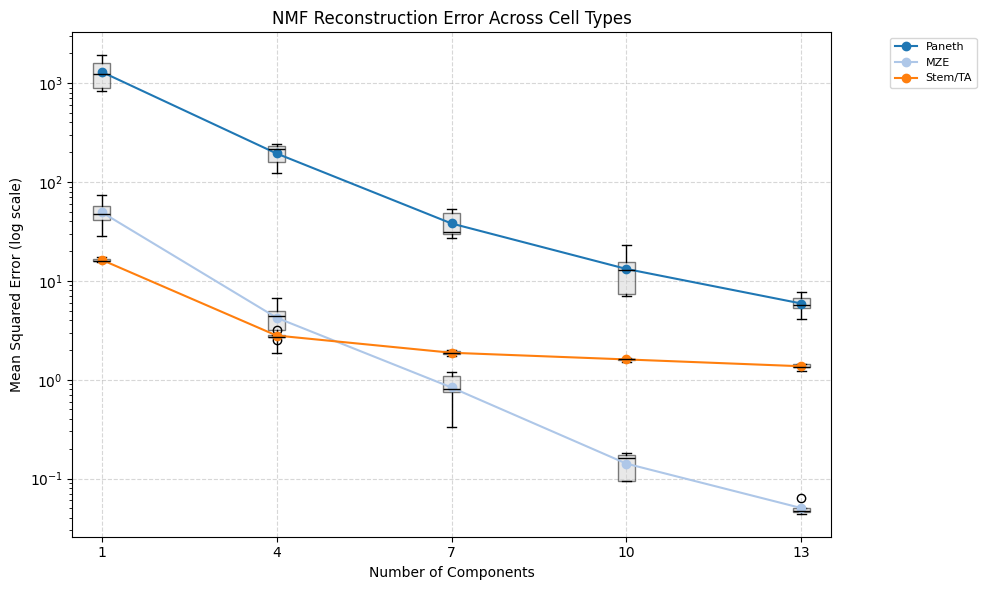

In [273]:
n_components_range = range(1, 15, 3) 
n_repeats = 5 
sample_fraction = 0.2 
cell_types = list(set(adata_sc.obs["cluster"]))[:3]  
palette = sns.color_palette("tab20", len(cell_types))
boxplot_data = {n: [] for n in n_components_range}
means = {n: [] for n in n_components_range}

for cell_type in cell_types:
    X_full = adata_sc[adata_sc.obs["cluster"] == cell_type].X.toarray().copy()
    n_samples = X_full.shape[0]
    for n_components in n_components_range:
        mse_values = []
        for _ in range(n_repeats):
            sampled_indices = np.random.choice(n_samples, int(sample_fraction * n_samples), replace=False)
            X_sampled = X_full[sampled_indices, :]
            W, H = non_negative_factorization(X_sampled, n_components=n_components)[:2]
            X_reconstructed = W @ H
            mse = sklearn.metrics.mean_squared_error(X_sampled, X_reconstructed)
            mse_values.append(mse)
        boxplot_data[n_components].append(mse_values)
        means[n_components].append(np.mean(mse_values))  # Store mean for line plot

plt.figure(figsize=(10, 6))

positions = list(n_components_range)
for i, n_components in enumerate(n_components_range):
    plt.boxplot(
        boxplot_data[n_components], 
        positions=[positions[i]] * len(cell_types),
        widths=0.3, 
        patch_artist=True, 
        boxprops=dict(facecolor="lightgray", alpha=0.5), 
        medianprops=dict(color='black')
    )

for i, (cell_type, color) in enumerate(zip(cell_types, palette)):
    mean_values = [means[n][i] for n in n_components_range]
    plt.plot(positions, mean_values, marker="o", linestyle="-", color=color, label=cell_type)

plt.xticks(positions, n_components_range)  
plt.xlabel("Number of Components")
plt.ylabel("Mean Squared Error (log scale)")
plt.yscale("log")
plt.title("NMF Reconstruction Error Across Cell Types")
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

In [189]:
test_dict = {
    celltype: {
        n_components: 
        non_negative_factorization(adata_sp[adata_sp.obs["nico_ct"] == celltype].X.toarray().copy(), n_components=n_components)
    } for celltype, n_components in itertools.product(set.intersection(set(adata_sc.obs["cluster"]), set(adata_sp.obs["nico_ct"])), range(1, 10))
}

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

In [179]:
[adata_sp[adata_sp.obs["nico_ct"] == celltype].X.toarray().copy() for celltype in set.intersection(set(adata_sc.obs["cluster"]), set(adata_sp.obs["nico_ct"]))]

[array([[0.        , 0.        , 0.14867298, ..., 0.        , 0.90392554,
         0.        ],
        [0.5784428 , 0.        , 0.        , ..., 0.81999385, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.81666386, 1.213926  ,
         2.2594726 ],
        ...,
        [0.7476393 , 0.        , 0.        , ..., 1.015086  , 0.        ,
         0.        ],
        [1.050147  , 0.        , 1.1670045 , ..., 0.        , 0.        ,
         0.18060686],
        [1.399541  , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([[0.04509931, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.3005874 ,
         0.        ],
        ...,
        [0.        , 0.2339207 , 0.        , ..., 0.        , 0.        ,
         0.        

In [175]:
[non_negative_factorization(X_sp, n_components=n_components) for n_components in range(1, 10)]

[(array([[0.4527601 ],
         [0.38538107],
         [0.19495751],
         [0.10805941],
         [0.3555622 ],
         [0.3810317 ],
         [0.27717713],
         [0.2283019 ],
         [0.43779358],
         [0.22659318],
         [0.31427115],
         [0.16786313],
         [0.29841504],
         [0.31460178],
         [0.4558821 ],
         [0.37454307],
         [0.42977196],
         [0.23183192],
         [0.4064302 ],
         [0.28315377],
         [0.25313553],
         [0.26489896],
         [0.27550963],
         [0.4539555 ],
         [0.36933982],
         [0.4857205 ],
         [0.5033326 ],
         [0.1607699 ],
         [0.24643393],
         [0.27775994],
         [0.18104093],
         [0.4555408 ],
         [0.17836164],
         [0.26421437],
         [0.28009808],
         [0.37863198],
         [0.6172331 ],
         [0.2987241 ],
         [0.55816334],
         [0.23112564],
         [0.57748854],
         [0.26456508],
         [0.33535072],
         [0

In [92]:
H.shape

(3, 420)

In [97]:
W.T.shape

(3, 32287)

In [91]:
W.shape

(32287, 3)

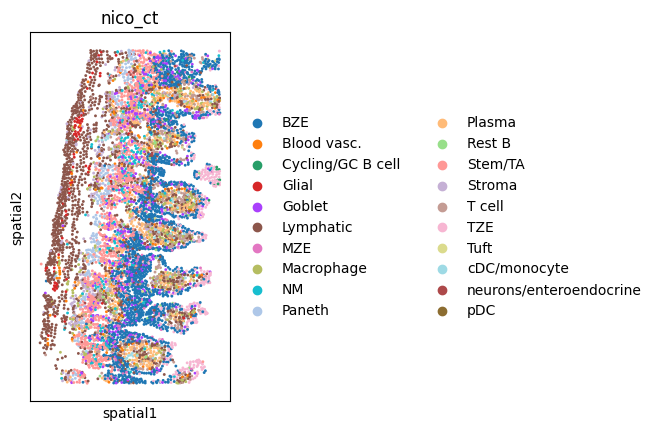

In [147]:
sc.pl.spatial(adata_sp, spot_size=80, color="nico_ct")

In [140]:
adata_sp.uns["spatial"]

KeyError: 'spatial'

In [141]:
sc.read_h5ad(Path.cwd() / "data" / "inputQuery" / "sct_spatial.h5ad")

AnnData object with n_obs × n_vars = 7416 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [143]:
adata_sp

AnnData object with n_obs × n_vars = 7416 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'